In [1]:
%matplotlib inline

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
from tensorflow.keras import layers, models

import numpy as np

2024-07-30 11:21:29.211675: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 11:21:29.227357: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-30 11:21:29.231937: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_images_path = './data/train'
train_masks_path = './data/train-masks'

In [4]:
test_images_path = './data/test'
test_masks_path = './data/test-masks'

In [5]:
# there is no annotations for this image in .json
# TODO: make check on this file if exists
# if not os.remove(f"{train_images_path}/2369_jpg.rf.8b8afa9d79c61fa42ca128c940b9cbc0.jpg"):
#     pass

In [6]:
def load_images(image_dir, mask_dir):
    images = []
    masks = []
    for filename in os.listdir(image_dir):
        if filename.endswith('.coco.json'):
            continue
        
        img = tf.keras.preprocessing.image.load_img(os.path.join(image_dir, filename), target_size=(128, 128))
        img = tf.keras.preprocessing.image.img_to_array(img)
        img /= 255.0
        images.append(img)
        
        mask = tf.keras.preprocessing.image.load_img(os.path.join(mask_dir, filename), color_mode="grayscale", target_size=(128, 128))
        mask = tf.keras.preprocessing.image.img_to_array(mask)
        mask /= 255.0
        masks.append(mask)
    
    return np.array(images), np.array(masks)

In [7]:
X_train, y_train = load_images(image_dir=train_images_path, mask_dir=train_masks_path)

In [8]:
if len(X_train) != len(y_train):
    raise ValueError(f"Number of training images ({len(X_train)}) and masks ({len(y_train)}) do not match.")

In [9]:
X_train.shape, y_train.shape

((1501, 128, 128, 3), (1501, 128, 128, 1))

In [10]:
def unet_model(input_size=(128, 128, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])

    return model


model = unet_model()

In [11]:
def dice_score(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

In [12]:
model = unet_model()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', dice_score])

In [13]:
X_test, y_test = load_images(test_images_path, test_masks_path)

In [14]:
model.fit(X_train, y_train, epochs=2, batch_size=16, validation_split=0.1)

Epoch 1/2
85/85 ━━━━━━━━━━━━━━━━━━━━ 825s 10s/step - accuracy: 0.9555 - dice_score: 0.0507 - loss: 0.2627 - val_accuracy: 0.9643 - val_dice_score: 0.0799 - val_loss: 0.1300
Epoch 2/2
85/85 ━━━━━━━━━━━━━━━━━━━━ 812s 10s/step - accuracy: 0.9626 - dice_score: 0.0812 - loss: 0.1325 - val_accuracy: 0.9643 - val_dice_score: 0.0887 - val_loss: 0.1250


In [15]:
model.evaluate(X_test, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 40s 6s/step - accuracy: 0.9637 - dice_score: 0.0940 - loss: 0.1243


[0.12563540041446686, 0.9633658528327942, 0.09358344972133636]

In [16]:
predicted_imgs = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step


In [17]:
def display_images(input_img, predicted_img, true_img):
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Відображення вхідного зображення
    axes[0].imshow(input_img.squeeze(), cmap='gray')
    axes[0].set_title('Input Image')
    axes[0].axis('off')
    
    # Відображення передбаченого зображення
    axes[1].imshow(predicted_img.squeeze(), cmap='gray')
    axes[1].set_title('Predicted Image')
    axes[1].axis('off')
    
    # Відображення справжнього зображення
    axes[2].imshow(true_img.squeeze(), cmap='gray')
    axes[2].set_title('True Image')
    axes[2].axis('off')
    
    plt.show()

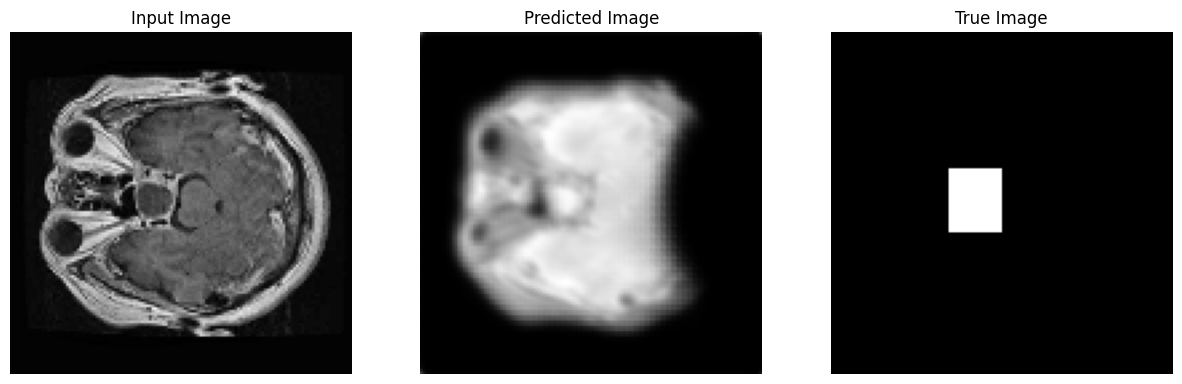

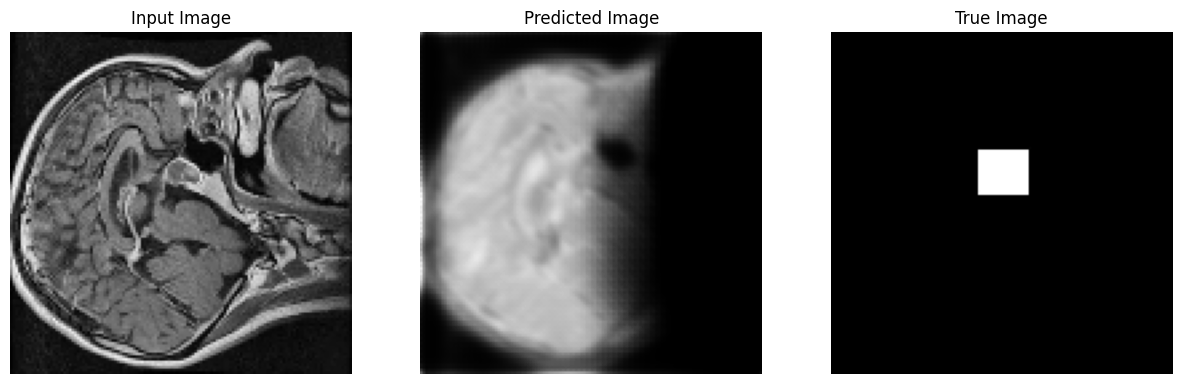

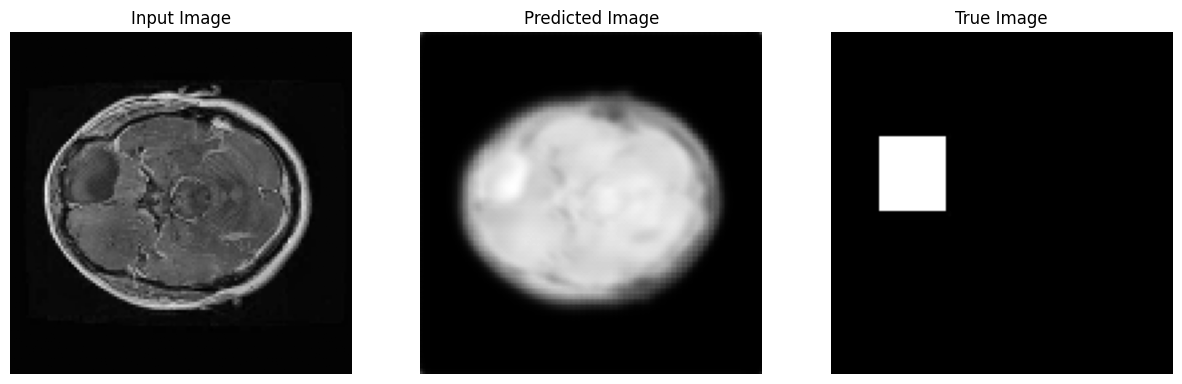

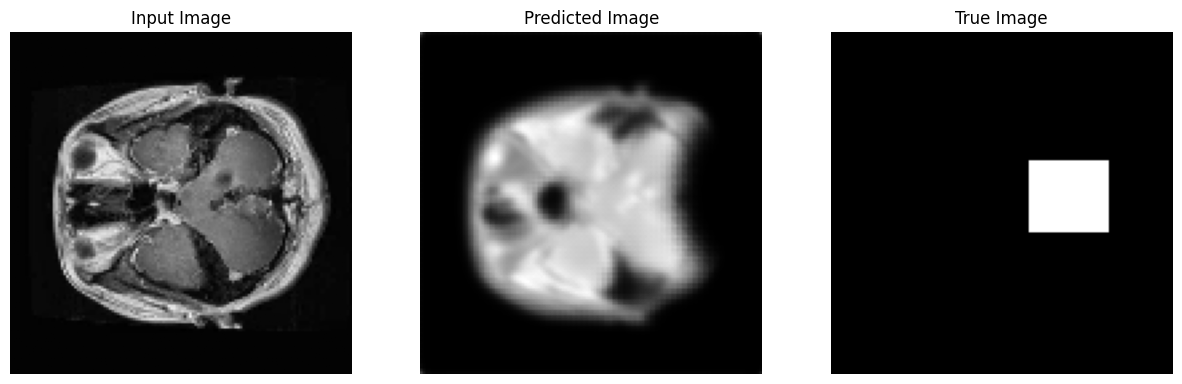

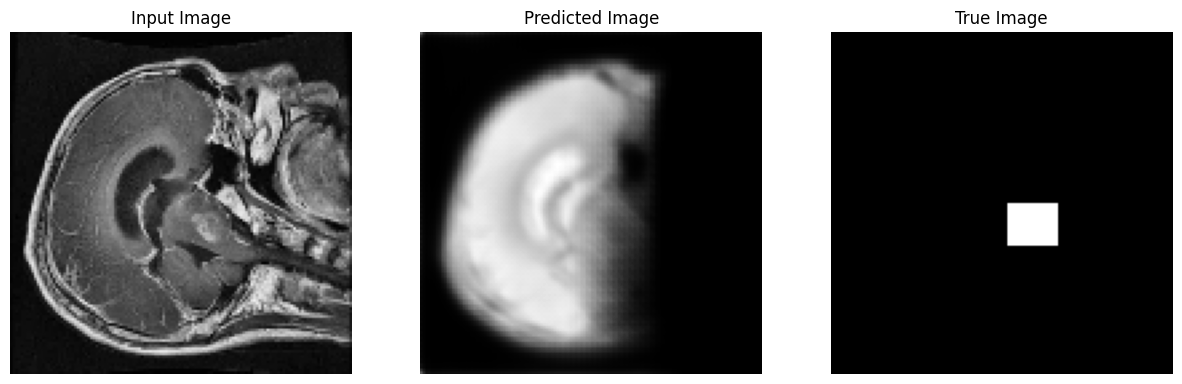

In [18]:
for i in range(5):  # Наприклад, перші 5 зображень
    display_images(X_test[i], predicted_imgs[i], y_test[i])